# Load Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Load Data & Data Preparation

In [4]:
df = pd.read_csv("./data/04-Telco Customer Churn.csv")

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

# Train the Model

In [5]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [6]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [7]:
C = 1.0
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1.0 0.840 +- 0.008


In [8]:
scores

[0.8420649810426168,
 0.8437934545093365,
 0.832398153722657,
 0.8301724275756219,
 0.8510322864045685]

In [9]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

y_test = df_test.churn.values

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

# Saving and Loading the Model

## Save the Model

In [10]:
import pickle

In [12]:
# file name
output_file = f'model_C={C}.bin'
output_file

'model_C=1.0.bin'

We need both dv and model to save.

In [13]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

## Load the Model

In [1]:
import pickle

In [2]:
model_file = 'model_C=1.0.bin'

In [3]:
with open(model_file, 'rb') as f_in:
    (dv, model) = pickle.load(f_in)

In [4]:
 dv, model

(DictVectorizer(sparse=False), LogisticRegression(max_iter=1000))

In [5]:
customer = {
    "gender": "female",
    "seniorcitizen": 0,
    "partner": "yes",
    "dependents": "no",
    "phoneservice": "no",
    "multiplelines": "no_phone_service",
    "internetservice": "dsl",
    "onlinesecurity": "no",
    "deviceprotection": "no",
    "techsupport": "no",
    "streamingtv": "no",
    "streamingmovies": "no",
    "contract": "month-to-month",
    "paperlessbilling": "yes",
    "paymentmethod": "electronic_check",
    "tenure": 1,
    "monthlycharges": 29.85,
    "totalcharges": 29.85
}

In [6]:
# turn this customer into a feature matrix
X = dv.transform([customer])

In [7]:
X

array([[ 1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  1.  ,  0.  ,  0.  , 29.85,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,
         0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  , 29.85]])

In [9]:
# get churn probability
model.predict_proba(X)[0, 1]

0.6638191204267414

This is how a model can be saved and loaded later for prediction. However, it is not convinient to do in a jupyter notebook every time, so imagine that you want to train a model, you don't want to open the jupyter notebook and execute all the cells. So We want to have a single python file (a script that just does that).

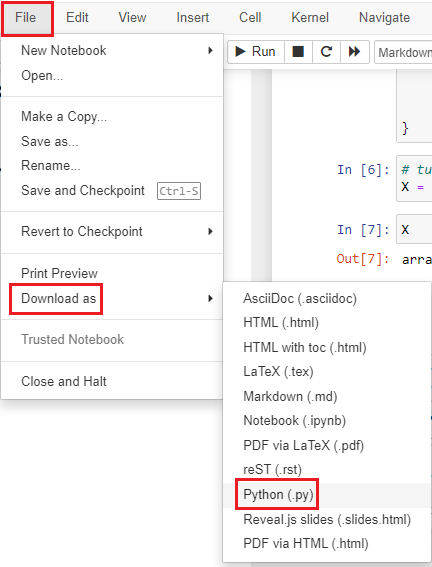

Take the code where you need it and clean it.
- Put all the import at the top
- Put parameters after imports
- Put the model loading in a new notebook (predict.py)
- Add a few logging (prints) in the code
- Run the code and then take a look at the size of the file: ls -lh 'filename.bin'
- Now, you can use the model (predict.py)

# Web Services: Introduction to Flask

[What are web services?](https://en.wikipedia.org/wiki/Web_service) A web service (WS) is either:
- a service offered by an electronic device to another electronic device, communicating with each other via the Internet, or
- a server running on a computer device, listening for requests at a particular port over a network, serving web documents (HTML, JSON, XML, images).

Watch this [video](https://www.youtube.com/watch?v=e3bz4dxoUII).

Flask is a web application framework written in Python. Now, install flask:
https://flask.palletsprojects.com/en/2.2.x/installation/

- Build your app with flask
    - It should be in the main level
- Run the python script where your app is in it
- Open a new terminal
- Use `curl` to communicate with web services
    - For example, ‘0.0.0.0:9696`
    - By default, it is http, we can keep it or remove it.
    - Then, the address is ping: ‘http://0.0.0.0:9696/ping`
    - You can also use localhost: ‘http://localhost:9696/ping`
    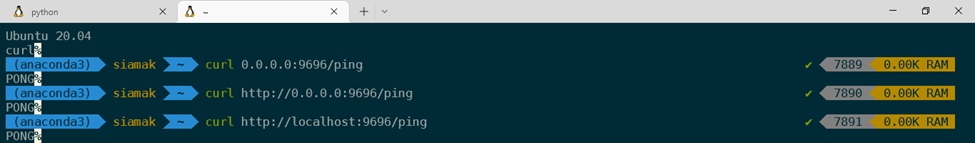
    - We can also do this from a browser, because it is a `GET` request.
    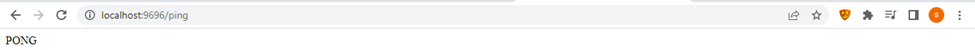
- You can see the list of access
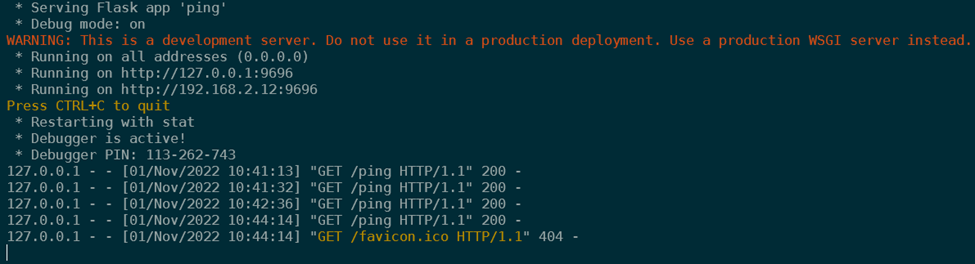

You can use streamlit to show case the results. 

https://www.youtube.com/watch?v=4V3VACzOmrI

# Serving the Churn Model with Flask

We want to get some information about the customer and then we want to reply with the churn probability.

We provide the information of customer in a JSON file. JSON file is like a python dictionary, but instead of single quote, we need to use double quote.

Then, we need to tell flask that we are using JSON:

and finally we want to return a JSON file:

Create a new jupyter notebook and from that we want to communicate with the churn prediction service.

**Note** that previously we could communicate with the web browser but now we cannot because the browser send a `GET` request and you see 405 meaning it is not allowed and the only allowed method is `POST`, and it is not easy from a browser.

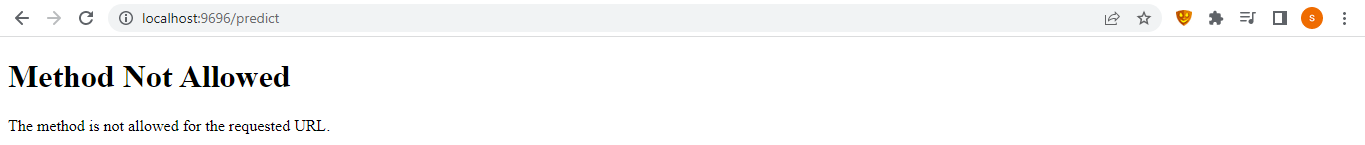

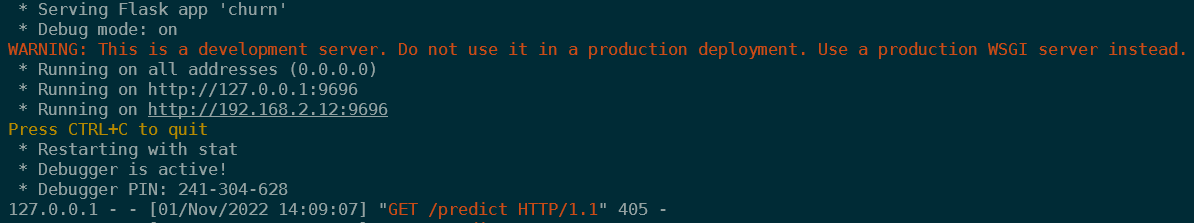

So, what we want to do is that we want to do it from python and use request library.

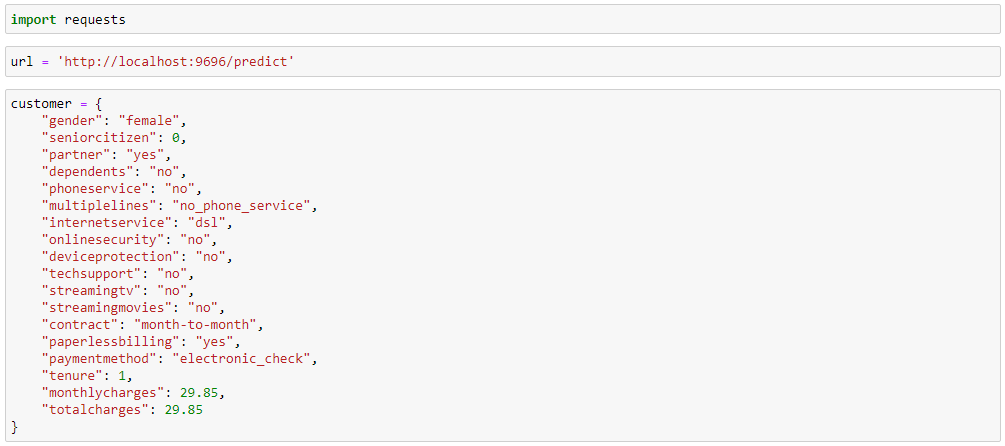

Now, what we want to do is to send this customer in a post request.

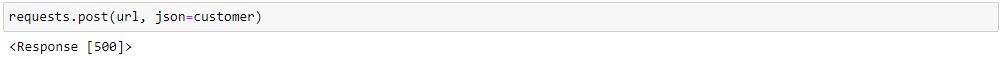

Response with 500 is an error

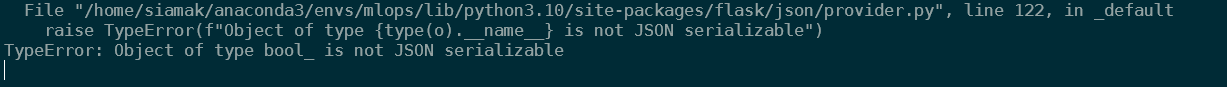

The reason for this error is **bool_** which comes from **numpy** that JSON class in python doesn't know how to turn the objects of this class into text, but it knows how to turn the usual boolean types in python to text.  

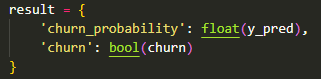

Because we run the flask in the debug mode, it detects the change in the file and reload the web service. Now, we don't need to stop it and restart it. It we run the `requests.post()` again, we will get 200 which means it was successful.

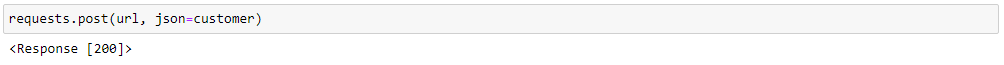

We can use .json() which takes the content of the request and turn it into a python dictionary.

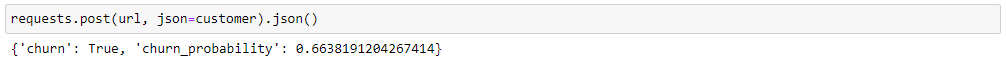

Now, you can change the information of the customer and run the model again and see the results.

This is how we turned our predict script to a web service.

If you run the predict script, you see a warning.

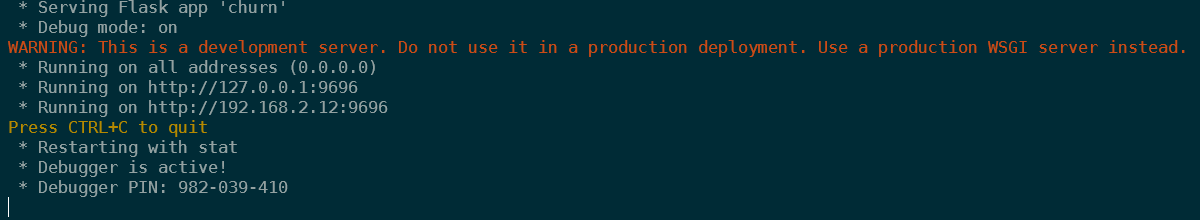

 If you are wonder to what to do in this case, so what we need to do here is instead of using plain flask, we need to use WSGI server. There are many different WSGI servers on python, I usually use gunicorn. We need to install it first 

The way we use gunicorn is as follows:

This is how you turn a flask app into something production related and we will use it for deploying services.

**Note** if you are using plain windows the gunicorn will not work. gunicorn uses some linux or unix specific features, it works on macOS and linux, but it will not work on the windows. You can install waitress.